In [2]:
import os
import cv2
import json
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [3]:

json_folder = r'C:\Users\user\Desktop\SamatmodulA\train\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\train.csv'
#Открытие csv файла
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY'] # Название столбцов
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') # Занесение названий
    writer.writeheader()
    # Дальше проходимся по каждому json файлу и заносим в csv
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [4]:
json_folder = r'C:\Users\user\Desktop\SamatmodulA\val\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\val.csv'
#Открытие csv файла
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY'] # Название столбцов
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') # Занесение названий
    writer.writeheader()
    # Дальше проходимся по каждому json файлу и заносим в csv
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [5]:
# Чтение csv файлов
train = pd.read_csv(r'C:\Users\user\Desktop\SamatmodulA\train.csv')
valid = pd.read_csv(r'C:\Users\user\Desktop\SamatmodulA\val.csv')

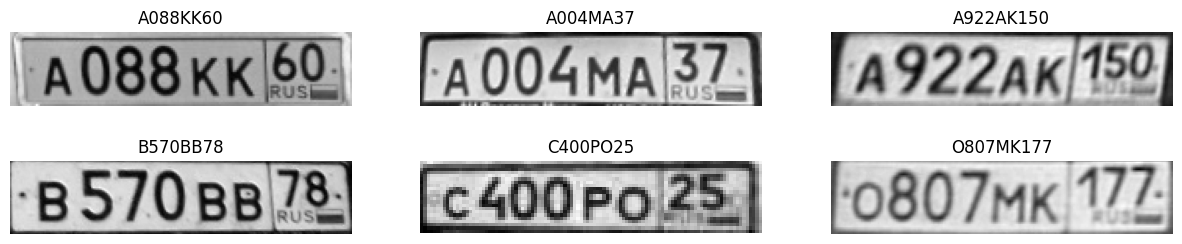

In [8]:
plt.figure(figsize=(15,10))
# Проверка на корректное расположение 
for i in range(6):
    ax = plt.subplot(2, 3, i+1) # Количество строк и столбцов в одном изоражении
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\train\\img\\' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE) # Оттенки серого
    plt.imshow(image, cmap = 'gray') # вывод изображения
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off') 

plt.subplots_adjust(wspace=0.2, hspace=-0.8) # расстояние между картинками

In [9]:
# Обработка изображений
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # оттенки серого
    
    # Обрезка
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # поворот на 90 градусов

In [10]:
# Количество изображений в папках
train_size = 49382
valid_size= 4893

In [11]:
train_x = []
# Добавление изображений в лист
for i in range(train_size):
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\train\\img\\'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [12]:
valid_x = []
# Добавление изображений в лист
for i in range(valid_size):
    img_dir = 'C:\\Users\\user\\Desktop\\SamatmodulA\\val\\img\\'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [13]:
# Преобразование массивов в четырехмерные
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [14]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890 "
max_str_len = 9
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64
batch_size = 128
# Функция, превращающая символ в цифру
def label_to_num(label):
    label_num = []
    for ch in label:
        
            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))
        
    return np.array(label_num)
# Функция, превращающая цифру в символ
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1: 
            break
        else:
            ret+=alphabets[ch]
    return ret

In [24]:
train_y = np.ones([train_size, max_str_len]) * -1 # Для хранения чисел
train_label_len = np.zeros([train_size, 1]) # Для хранения длины 
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2) # Для хранения длины входных данных
train_output = np.zeros([train_size]) # Для хранения длины выходных данных, пока что заполнен нулями

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [25]:
valid_y = np.ones([valid_size, max_str_len]) * -1 # Для хранения чисел
valid_label_len = np.zeros([valid_size, 1]) # Для хранения длины 
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2) # Для хранения длины входных данных
valid_output = np.zeros([valid_size]) # Для хранения длины выходных данных, пока что заполнен нулями

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [26]:
# Проверка
print('True label : ',train.loc[90, 'IDENTITY'] , '\ntrain_y : ',train_y[90],'\ntrain_label_len : ',train_label_len[90], 
      '\ntrain_input_len : ', train_input_len[90])

True label :  A109CC35 
train_y :  [ 0. 26. 35. 34.  2.  2. 28. 30. -1.] 
train_label_len :  [8.] 
train_input_len :  [62.]


In [27]:
input_data = Input(shape=(256, 64, 1), name='input') # Входной слой модели

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  # Сверточный слой с 32 фильтрами
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner) # Уменьшение размерности данных

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner) # Сверточный слой с 64 фильтрами
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) # Уменьшение размерности данных
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner) # Сверточный слой с 128 фильтрами
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner) # Уменьшение размерности данных
inner = Dropout(0.3)(inner)
# Изменение формы данных для слоя LTSM
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner) 
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) # Слой с 64 нейронами
# Добавление слоя с 256 нейронами
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner) # Вероятностное рапределение для каждого символа

model = Model(inputs=input_data, outputs=y_pred)
model.summary() # Вывод сводки модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [6]:
# Функция для расчета потерь для метода обучения без учителя
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [29]:
# Создание окончательной версии модели с использованием потерь

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [30]:
# Компиляция модели
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

c:\Users\user\Desktop\SamatmodulA\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
# Обучение модели
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=1, batch_size=128)

386/386 [==============================] - 897s 2s/step - loss: 26.2060 - val_loss: 24.7271


In [16]:
# Создаются предсказанные метки, преобразованные из числовых индексов в символы
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

NameError: name 'model' is not defined

In [15]:
# Проверка на корректность предсказания символов
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

NameError: name 'prediction' is not defined

In [ ]:
json_folder = r'C:\Users\user\Desktop\SamatmodulA\test\ann'

csv_file = r'C:\Users\user\Desktop\SamatmodulA\test.csv'
#Открытие csv файла
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY'] # Название столбцов
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',') # Занесение названий
    writer.writeheader()
    # Дальше проходимся по каждому json файлу и заносим в csv
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [ ]:
# Сохранение модели
tf.keras.models.save_model(model, "trained_model.h5")